In [24]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load #from this package, we obtain some useful datasets for our analysis.
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info

In [25]:
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Import personalized functions (Pandas API)

In [27]:
%run pandas-missing-extension.ipynb

### Setting up general project plot overview.

In [28]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8,6)
    }
)
sns.set_style("whitegrid")
sns.set_style("whitegrid")

### Loading NHANES data

In [29]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018") #column names are written in PascalCase
    .clean_names(case_type="snake")
)
nhanes_raw_df.shape

(8366, 197)

In [30]:
pd.set_option('display.max_rows', 25)

In [31]:
activity_df = (
    nhanes_raw_df.select_columns(
        "gender",
        "age_in_years_at_screening",
        "weight_kg", 
        "standing_height_cm",
        "vigorous_work_activity",
        "moderate_work_activity",
        "minutes_sedentary_activity", 
        "annual_household_income",
        "marital_status"
    )
    .rename_columns(
        {
            "weight_kg" : "weight",
            "standing_height_cm" : "height",
            "minutes_sedentary_activity" : "sedentary_time",
            "age_in_years_at_screening" : "age"
        }
    )
)
        

activity_df

,gender,age,weight,height,vigorous_work_activity,moderate_work_activity,sedentary_time,annual_household_income,marital_status
SEQN,,,,,,,,,
93703.0,Female,2.0,13.7,88.6,NaN,NaN,NaN,100000.0,NaN
93704.0,Male,2.0,13.9,94.2,NaN,NaN,NaN,100000.0,NaN
93705.0,Female,66.0,79.5,158.3,0.0,0.0,300.0,12500.0,Divorced
93706.0,Male,18.0,66.3,175.7,0.0,0.0,240.0,NaN,NaN
93707.0,Male,13.0,45.4,158.4,NaN,NaN,NaN,70000.0,NaN
...,...,...,...,...,...,...,...,...,...
102952.0,Female,70.0,49.0,156.5,0.0,0.0,120.0,17500.0,Married
102953.0,Male,42.0,97.4,164.9,1.0,1.0,360.0,NaN,Separated
102954.0,Female,41.0,69.1,162.6,0.0,0.0,600.0,70000.0,Never married


In [32]:
activity_df.marital_status.value_counts()

Married                2616
Never married           948
Divorced                597
Living with partner     478
Widowed                 427
Separated               194
Name: marital_status, dtype: int64

In [33]:
activity_df.describe()

,age,weight,height,vigorous_work_activity,moderate_work_activity,sedentary_time,annual_household_income
count,8366.000000,8242.000000,8016.000000,5527.000000,5528.000000,5.523000e+03,7237.000000
mean,35.830026,67.499260,156.593401,0.239732,0.418596,3.874525e+02,53585.118143
std,24.905061,31.377152,22.257858,0.426959,0.493374,7.603616e+02,32703.623008
min,1.000000,8.300000,78.300000,0.000000,0.000000,5.397605e-79,2000.000000
25%,12.000000,48.700000,151.400000,0.000000,0.000000,1.800000e+02,22500.000000
50%,33.000000,69.200000,161.900000,0.000000,0.000000,3.000000e+02,50000.000000
75%,59.000000,86.500000,171.200000,0.000000,1.000000,4.800000e+02,87500.000000
max,80.000000,242.600000,197.700000,1.000000,1.000000,9.999000e+03,100000.000000


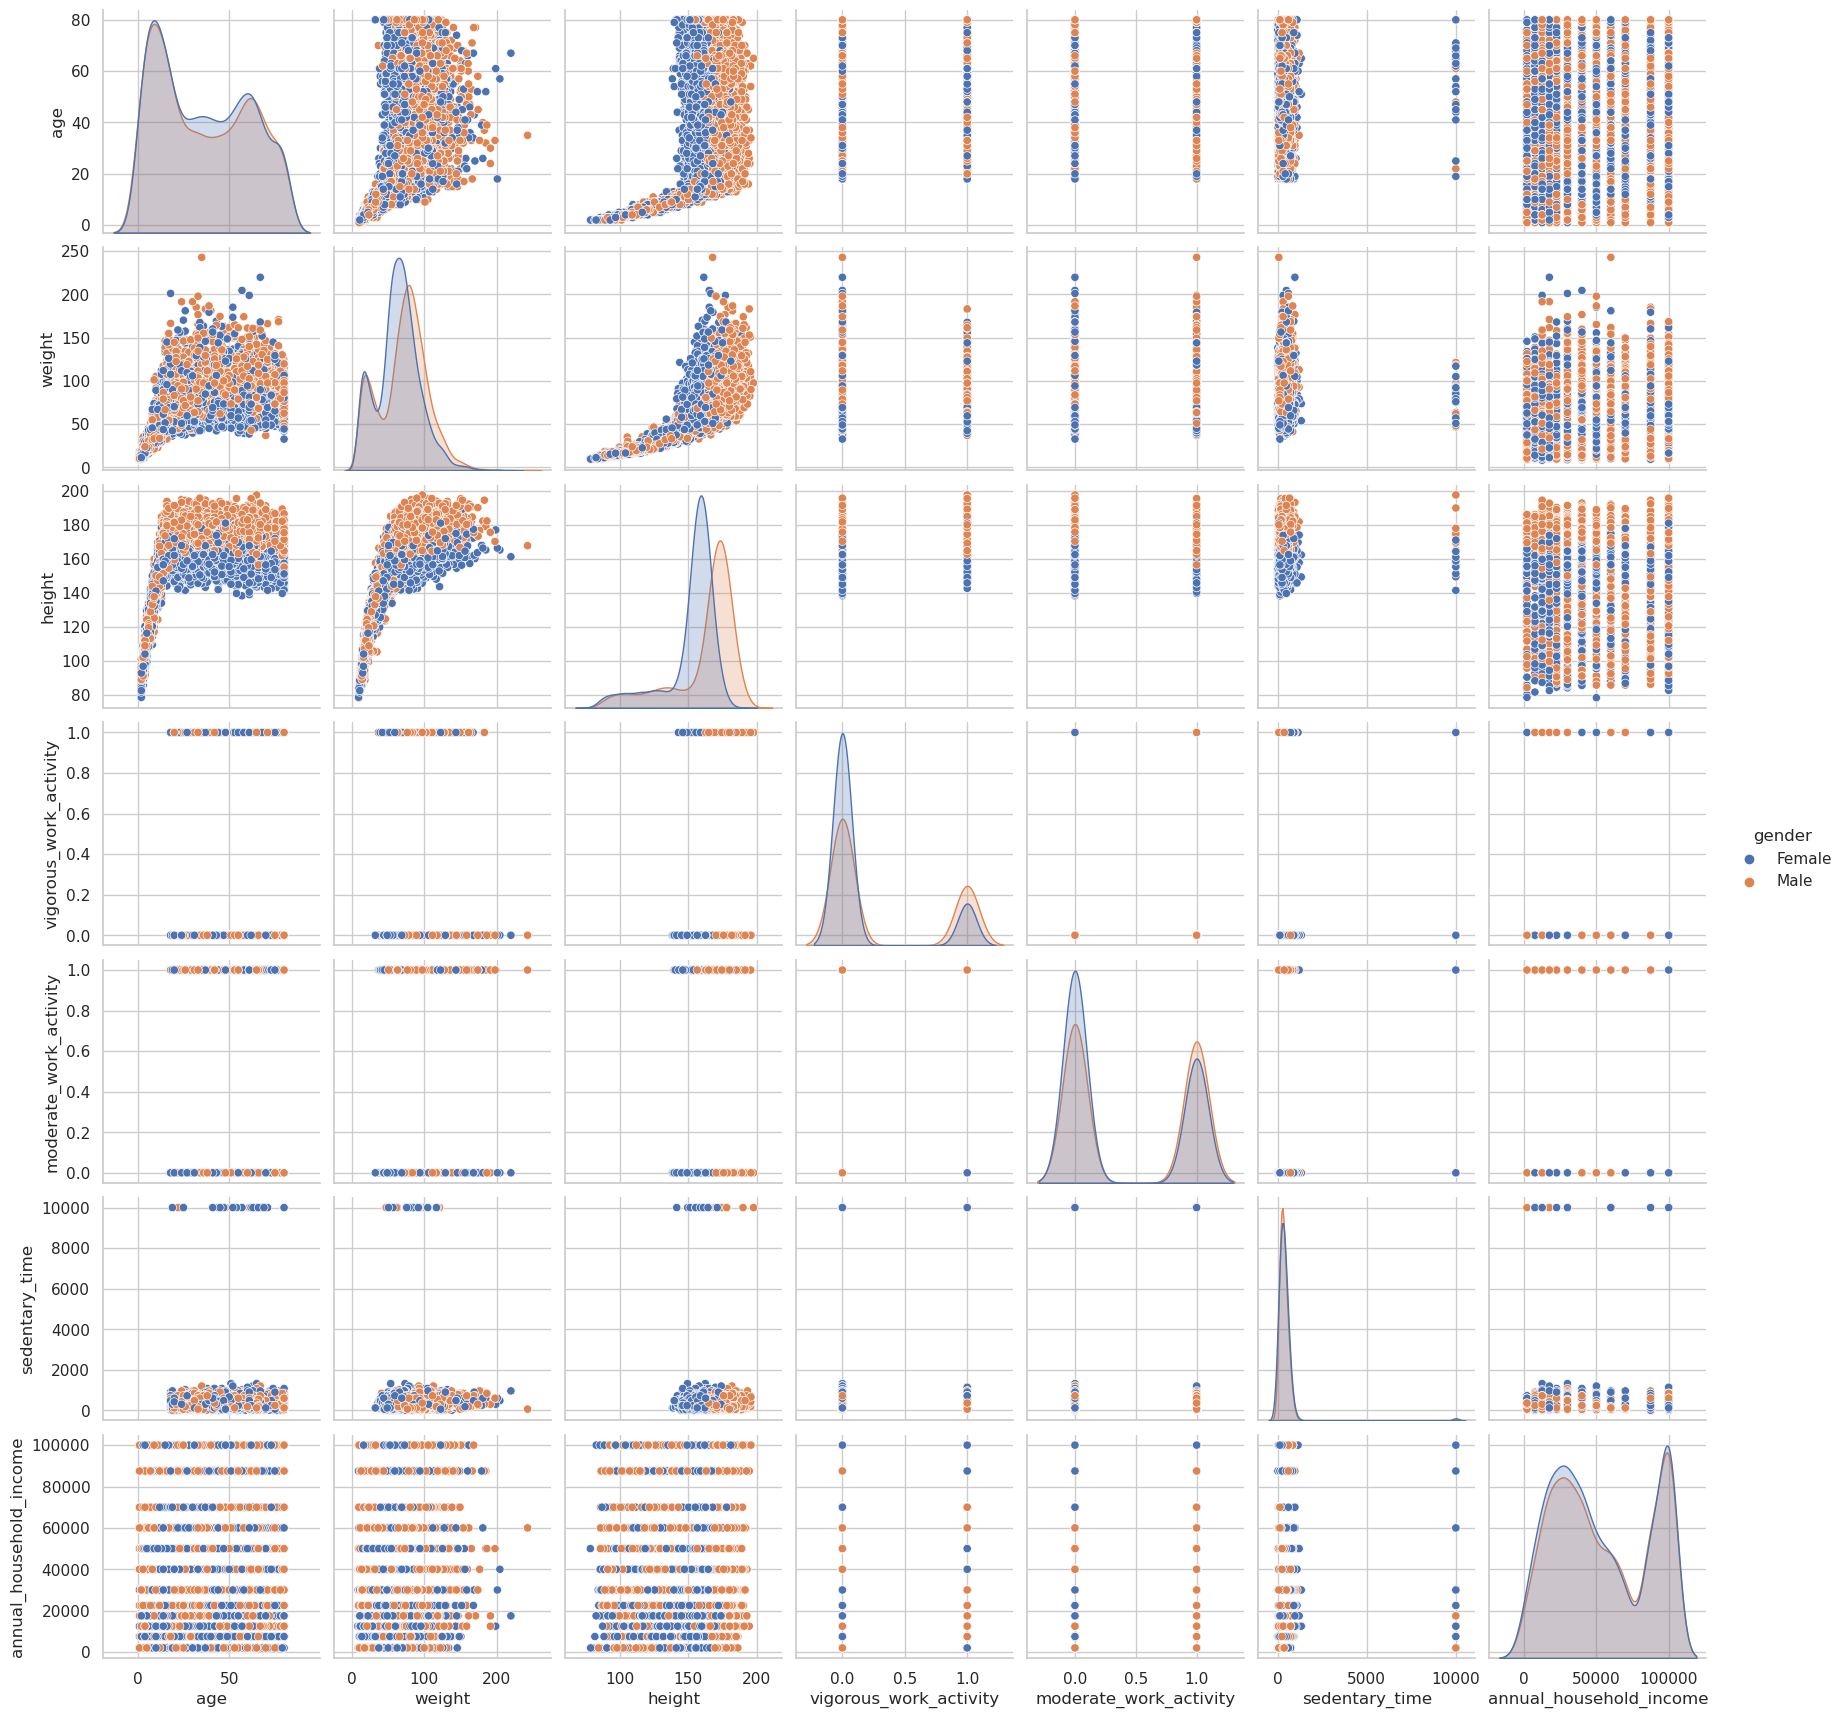

In [34]:
sns.pairplot(
    data=activity_df,
    hue="gender"
);

In [50]:
activity_df.vigorous_work_activity.dropna().sort_values(ascending=True).reset_index()

,SEQN,vigorous_work_activity
0,102883.0,0.0
1,102866.0,0.0
2,102868.0,0.0
3,102869.0,0.0
4,102870.0,0.0
...,...,...
5522,93715.0,1.0
5523,93738.0,1.0
5524,93752.0,1.0
5525,93743.0,1.0


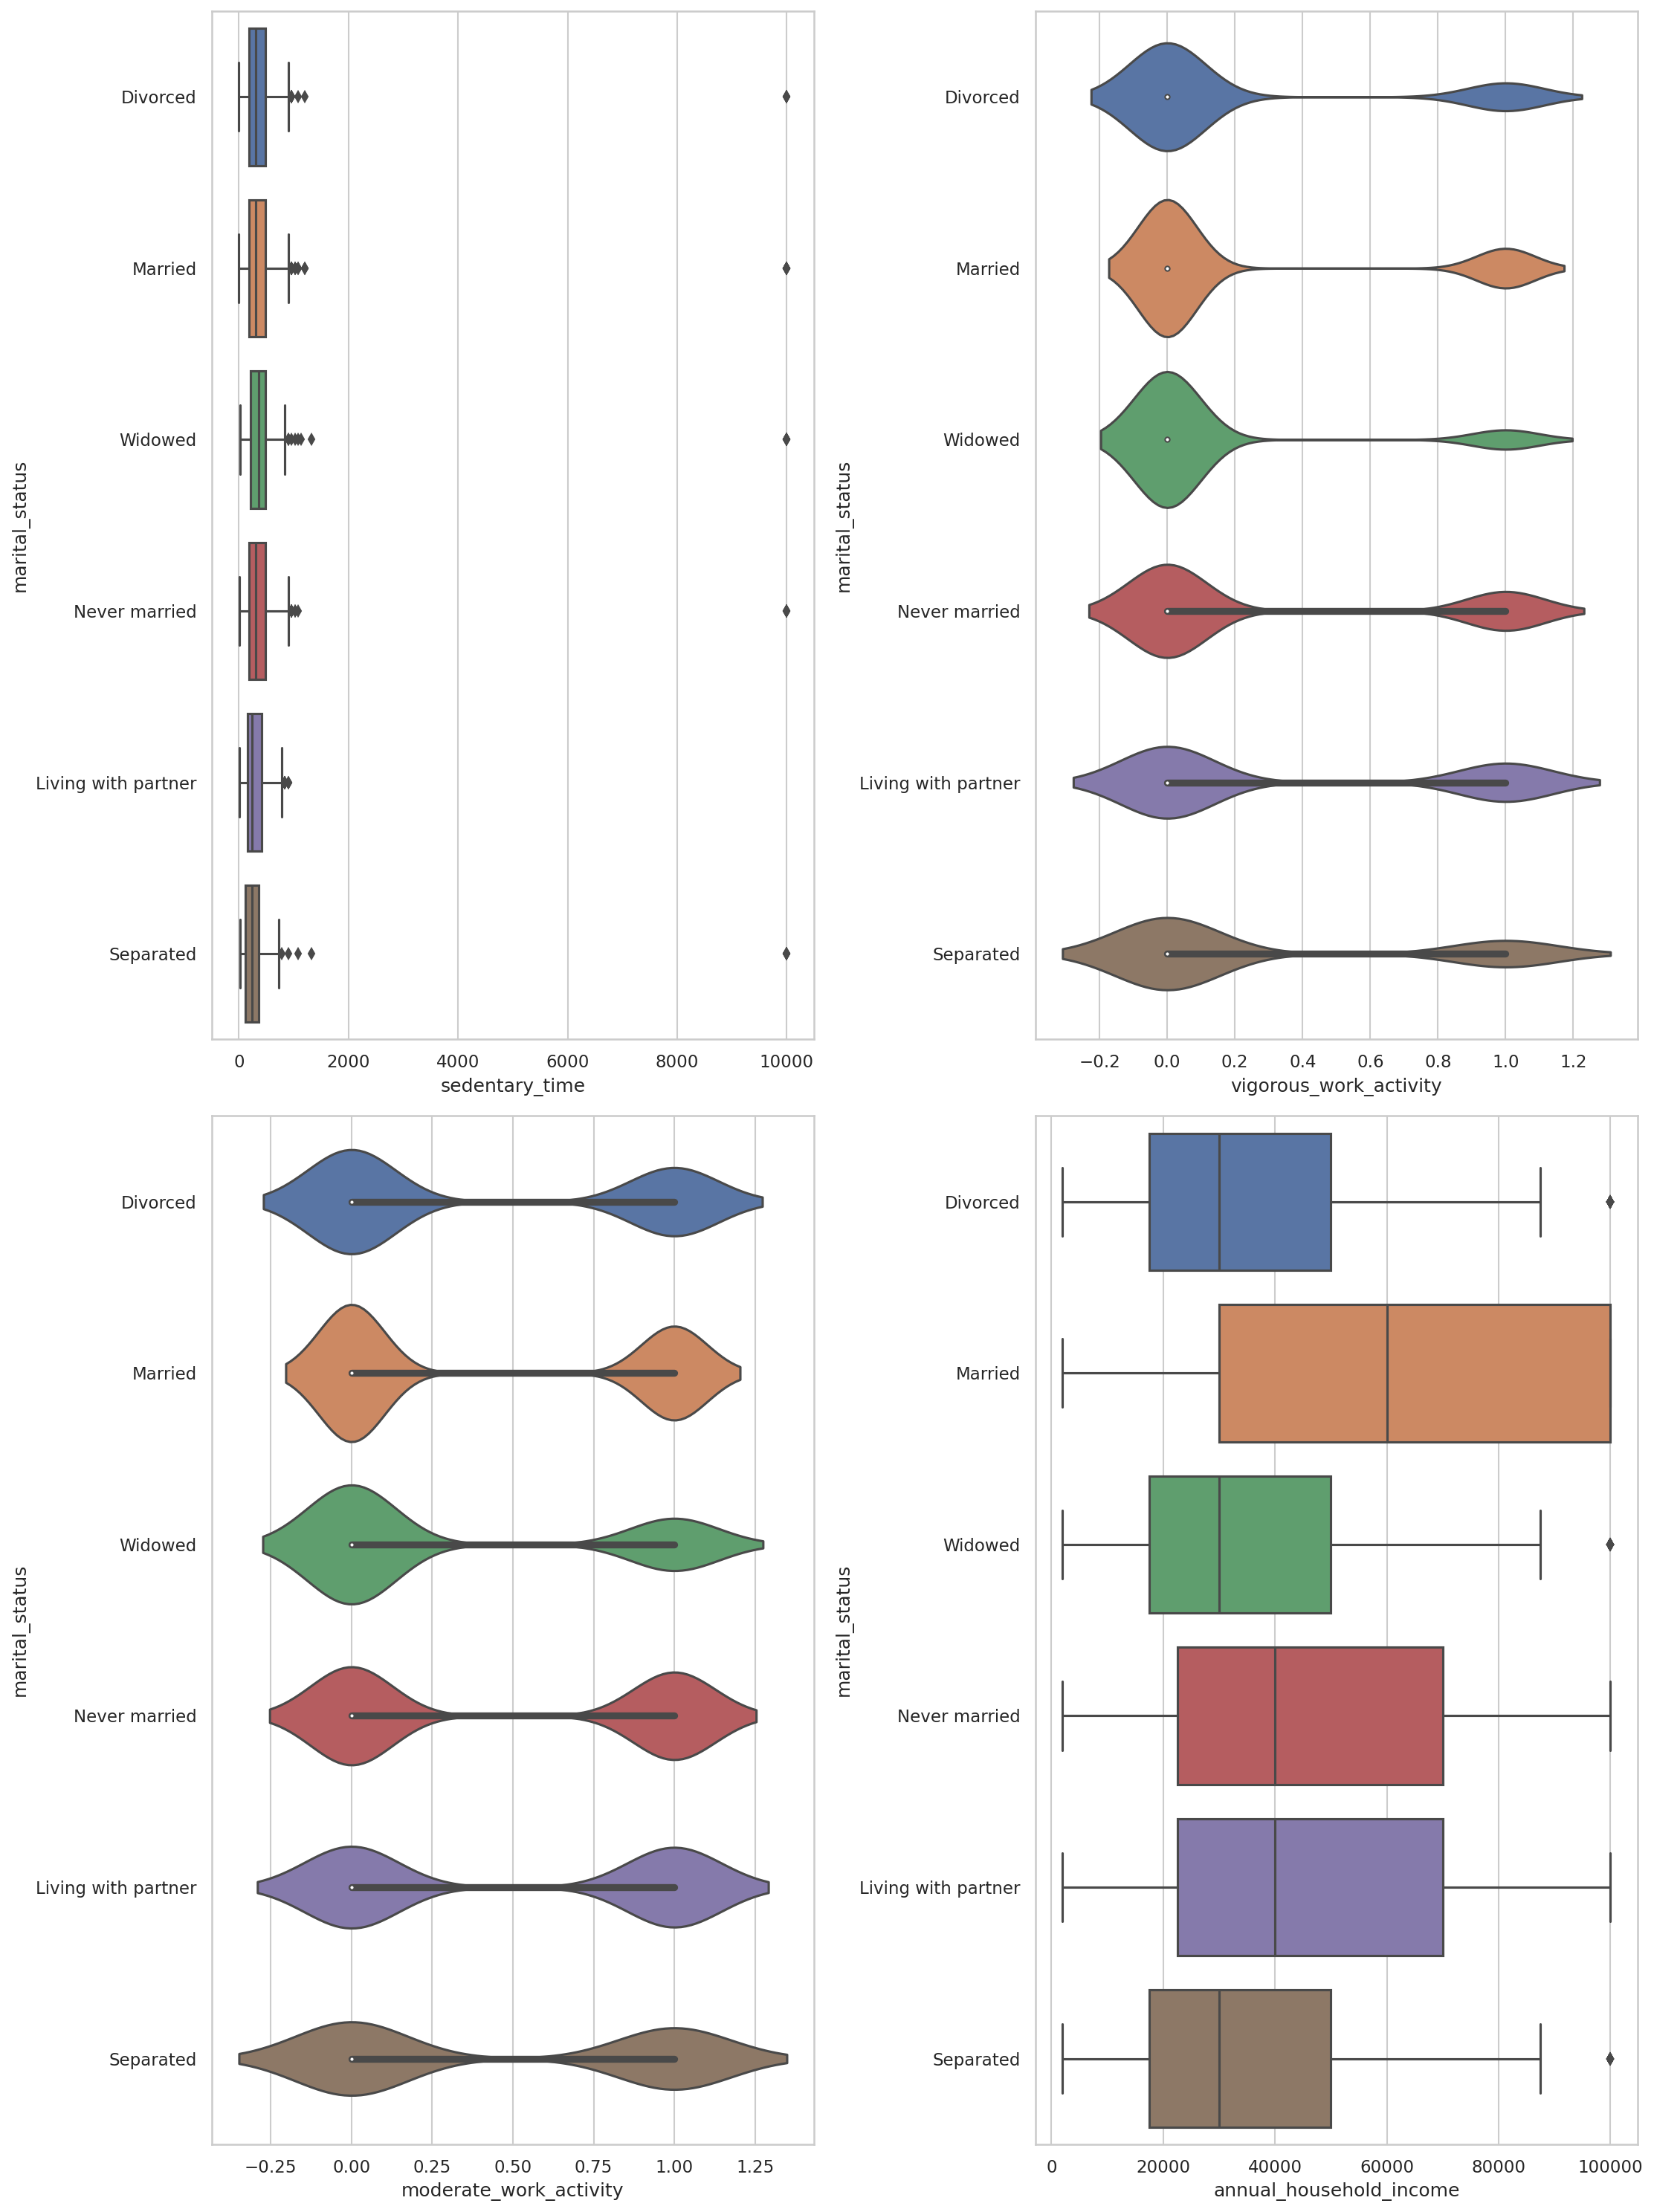

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 20), dpi=150)
plot_1_axes = sns.boxplot(data=activity_df, x="sedentary_time", y="marital_status", ax=axes[0,0])
plot_2_axes = sns.violinplot(data=activity_df, x="vigorous_work_activity", y="marital_status", showfliers=True, ax=axes[0,1])
plot_3_axes = sns.violinplot(data=activity_df, x="moderate_work_activity", y="marital_status", showfliers=True, ax=axes[1,0])
plot_4_axes = sns.boxplot(data=activity_df, x="annual_household_income", y="marital_status", ax=axes[1,1])
plt.tight_layout()

Our values does not present any implicit values which can modify our dramatically bias our analysis. In the case of weight and height, those outliers could be attributable to younger people, as children or short size people.

We can also infer that both `work_activity` variables are categorical encoded as 1 or 0, probably matching to `True` or `False`, these columns do not have any outliers different to 0 or 1.

Some abnormal values were found in the column `sedentary_time`, finding out a substantial gap between those value and outliers.

In [67]:
activity_df["sedentary_time"] = (
    activity_df.select_columns("sedentary_time")
    .sort_values(by="sedentary_time", ascending=False)
    .replace(
        {
            "sedentary_time" : {
                9999 : np.nan
                
            }
        }
    )
)

### Visualizing missing values of `activity_df`

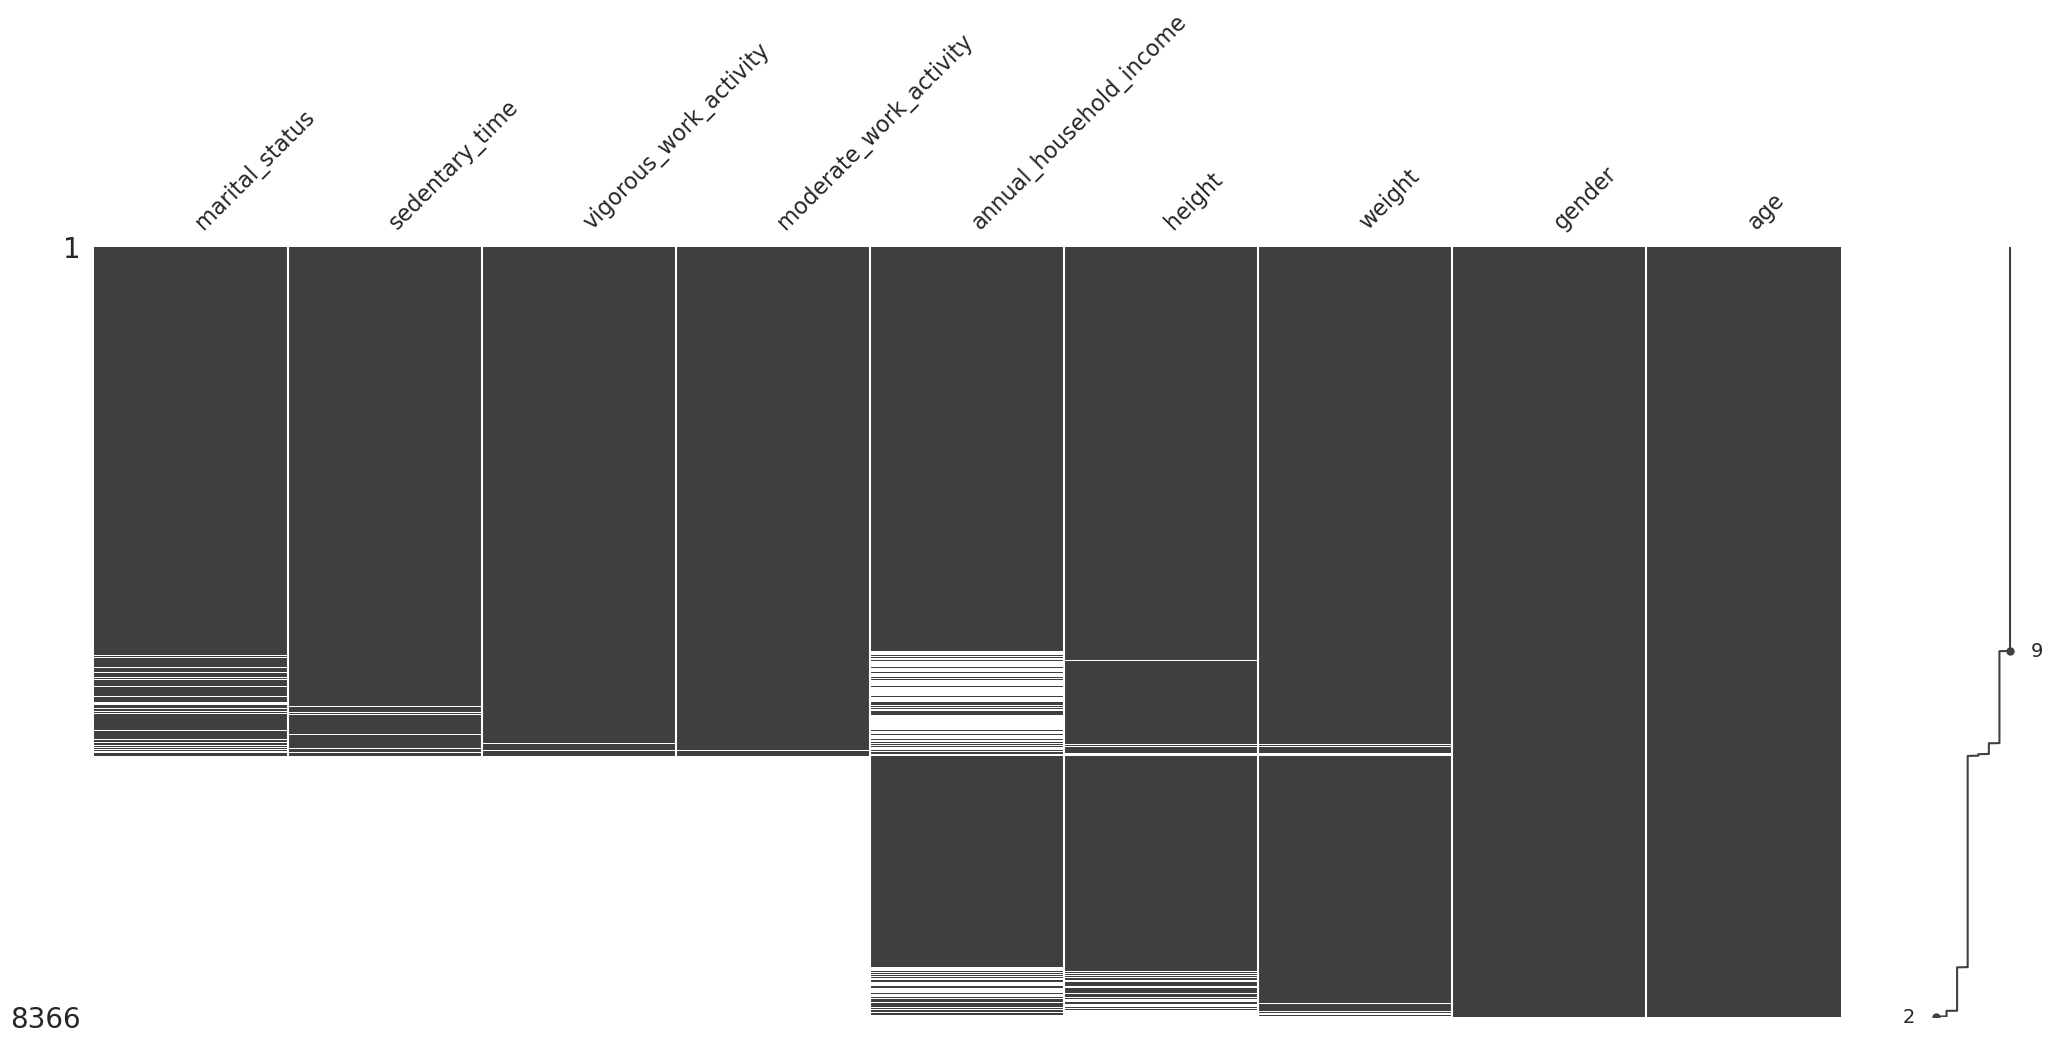

In [68]:
(
    activity_df
    .missing.sort_variables_by_missingness()
    .pipe(
        missingno.matrix,
        sort="descending"
    )
);

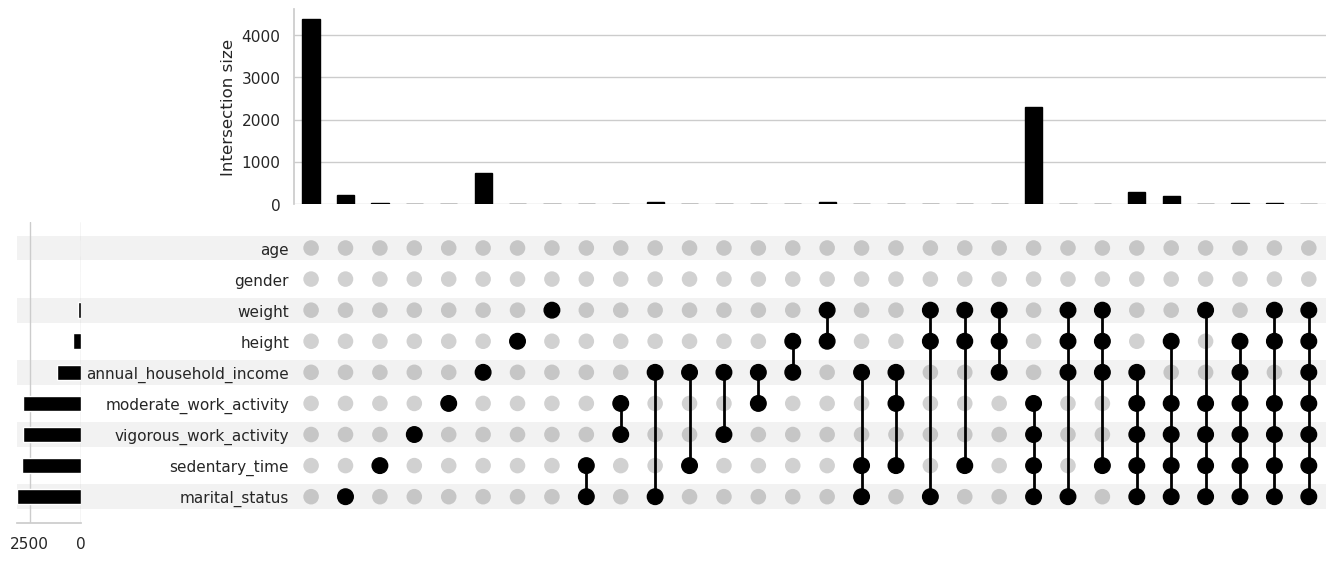

In [69]:
(
    activity_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
);

In [70]:
activity_dropped_na_df = (
        activity_df.copy(deep=True)
        .dropna(
            subset=["moderate_work_activity", "vigorous_work_activity", "sedentary_time", "marital_status"],
            how="all"
        )
        .missing.sort_variables_by_missingness()
)

print(f"The original shape of our activity_df dataset was {activity_df.shape[0]}, and our current is {activity_dropped_na_df.shape[0]}")

The original shape of our activity_df dataset was 8366, and our current is 5533


Due to strong relationship among `work_activity` variables and `marital_status` missing values, we could consider that mechanism is MAR, it is probably attributed to a survey non-response.

In [71]:
(
    activity_df
    .missing.missing_variable_summary()
    .assign(
        dtype = activity_df.dtypes.reset_index()[0]
    )
)

,variable,n_missing,n_cases,pct_missing,dtype
0,gender,0,8366,0.000000,object
1,age,0,8366,0.000000,float64
2,weight,124,8366,1.482190,float64
3,height,350,8366,4.183600,float64
4,vigorous_work_activity,2839,8366,33.934975,float64
5,moderate_work_activity,2838,8366,33.923022,float64
6,sedentary_time,2875,8366,34.365288,float64
7,annual_household_income,1129,8366,13.495099,float64
8,marital_status,3106,8366,37.126464,object


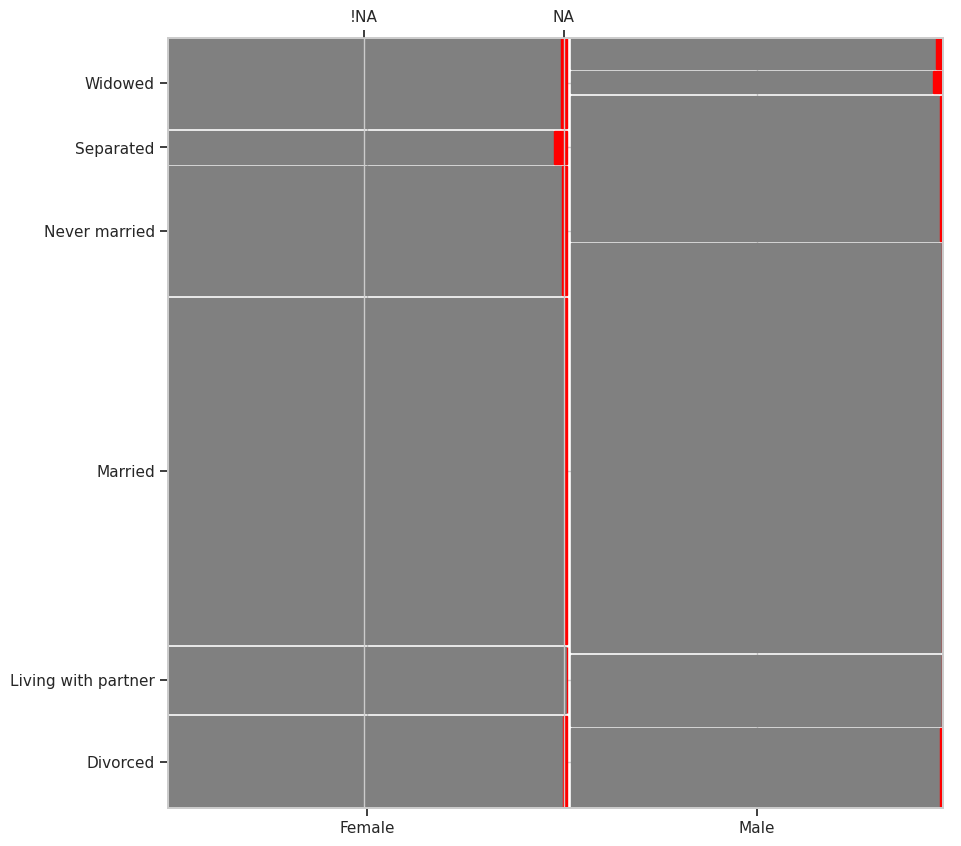

In [72]:
fig, ax = plt.subplots(figsize=(10,10))

(
    activity_df
    .select_columns("sedentary_time", "marital_status", "gender")
    .assign(
        sedentary_time=lambda df: df.sedentary_time.isna().replace([True, False], ["NA", "!NA"])
    )
    .groupby(
        ["gender", "marital_status", "sedentary_time"]
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color":"red" if "NA" in key else "gray"},
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
            ax=ax
        )
    )
);

### Encoding categorical variables

In [73]:
activity_df_transformed = activity_df.copy(deep=True)

In [75]:
ordinal_encoder = sklearn.preprocessing.OrdinalEncoder()
X = [["Male"], ["Female"], ["Female"]]

In [76]:
ordinal_encoder.fit_transform(X), ordinal_encoder.categories_

(array([[1.],
        [0.],
        [0.]]),
 [array(['Female', 'Male'], dtype=object)])

In [79]:
ordinal_encoder.inverse_transform([[0], [0], [1]])

array([['Female'],
       ['Female'],
       ['Male']], dtype=object)

##### Applying `ordinal coding` to categorical variables

In [83]:
categorical_columns = activity_df.select_dtypes(include=[object, "category"]).columns # work_activity columns are highly probably to be categorical.

In [85]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns), 
    remainder="passthrough"
)

In [97]:
activity_df_transformed = (
    pd.DataFrame(
        categorical_transformer.fit_transform(activity_df), # converts every categorical valuable into ordinal encodings.
        columns=categorical_transformer.get_feature_names_out(), # remained_ and ordinalencoder_ is added to our original columns name.
        index=activity_df.index
    )
    .rename_columns(
        function=lambda x:x.removeprefix("ordinalencoder__") # removes "ordinalencoder__" prefix that is naturally added.
    )
    .rename_columns(
        function=lambda x:x.removeprefix("remainder__")
    )
)

##### Applying `one-hot encoding` to categorical variables

In [99]:
(
    activity_df
    .select_columns("marital_status")
    .pipe(
        pd.get_dummies
    )
    .rename_columns(
        function=lambda x:x.removeprefix("marital_status_")
    )
)

,Divorced,Living with partner,Married,Never married,Separated,Widowed
SEQN,,,,,,
93703.0,0,0,0,0,0,0
93704.0,0,0,0,0,0,0
93705.0,1,0,0,0,0,0
93706.0,0,0,0,0,0,0
93707.0,0,0,0,0,0,0
...,...,...,...,...,...,...
102952.0,0,0,1,0,0,0
102953.0,0,0,0,0,1,0
102954.0,0,0,0,1,0,0


Those dummy generated values could not be accessed from other methods in order to match its coded value with categorical one. Meanwhile with `sklearn.preprocessing.OneHotEncoder()`, that is completely possible and more recommended.

In [101]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]), # Applying OneHot Encoding to "gender" variable is useless, cause with have bivariate values.
    (sklearn.preprocessing.OneHotEncoder(), ["marital_status"]),
    remainder="passthrough"
)

In [103]:
activity_df_transformed_2 = (
    pd.DataFrame(
        transformer.fit_transform(activity_df),
        columns=transformer.get_feature_names_out(), # remained_ and ordinalencoder_ is added to our original columns name.
        index=activity_df.index
    )
    .rename_columns(
        function=lambda x:x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function=lambda x:x.removeprefix("remainder__")
    )
    .rename_columns(
        function=lambda x:x.removeprefix("onehotencoder__marital_status_")
    )
)

activity_df_transformed_2

,gender,Divorced,Living with partner,Married,Never married,Separated,Widowed,nan,age,weight,height,vigorous_work_activity,moderate_work_activity,sedentary_time,annual_household_income
SEQN,,,,,,,,,,,,,,,
93703.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,13.7,88.6,NaN,NaN,NaN,100000.0
93704.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,13.9,94.2,NaN,NaN,NaN,100000.0
93705.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,79.5,158.3,0.0,0.0,300.0,12500.0
93706.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,66.3,175.7,0.0,0.0,240.0,NaN
93707.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,45.4,158.4,NaN,NaN,NaN,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,70.0,49.0,156.5,0.0,0.0,120.0,17500.0
102953.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,42.0,97.4,164.9,1.0,1.0,360.0,NaN
102954.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,41.0,69.1,162.6,0.0,0.0,600.0,70000.0


In [106]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Divorced', 'Living with partner', 'Married', 'Never married',
        'Separated', 'Widowed', nan], dtype=object)]

In [108]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0,0,1,0,0,0,0], [0,1,0,0,0,0,0]]
    )
)

array([['Married'],
       ['Living with partner']], dtype=object)

### Contrasting imputing methods
#### Single value imputing (by mean)

In [110]:
(
    activity_df
    .sedentary_time
    .mean()
)

331.43908213440176

In [111]:
(
    activity_df
    .transform_column(
        "sedentary_time",
        lambda x:x.fillna(x.mean()),
        elementwise=False
    )
    .sedentary_time
    .mean()
)

331.4390821344017

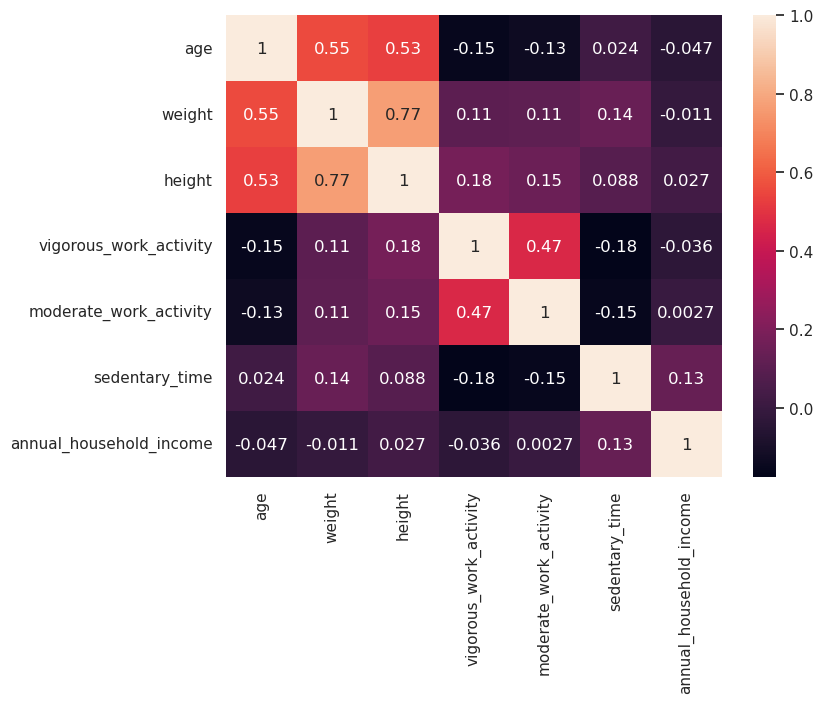

In [127]:
sns.heatmap(data=activity_df.corr(numeric_only=True), annot=True);

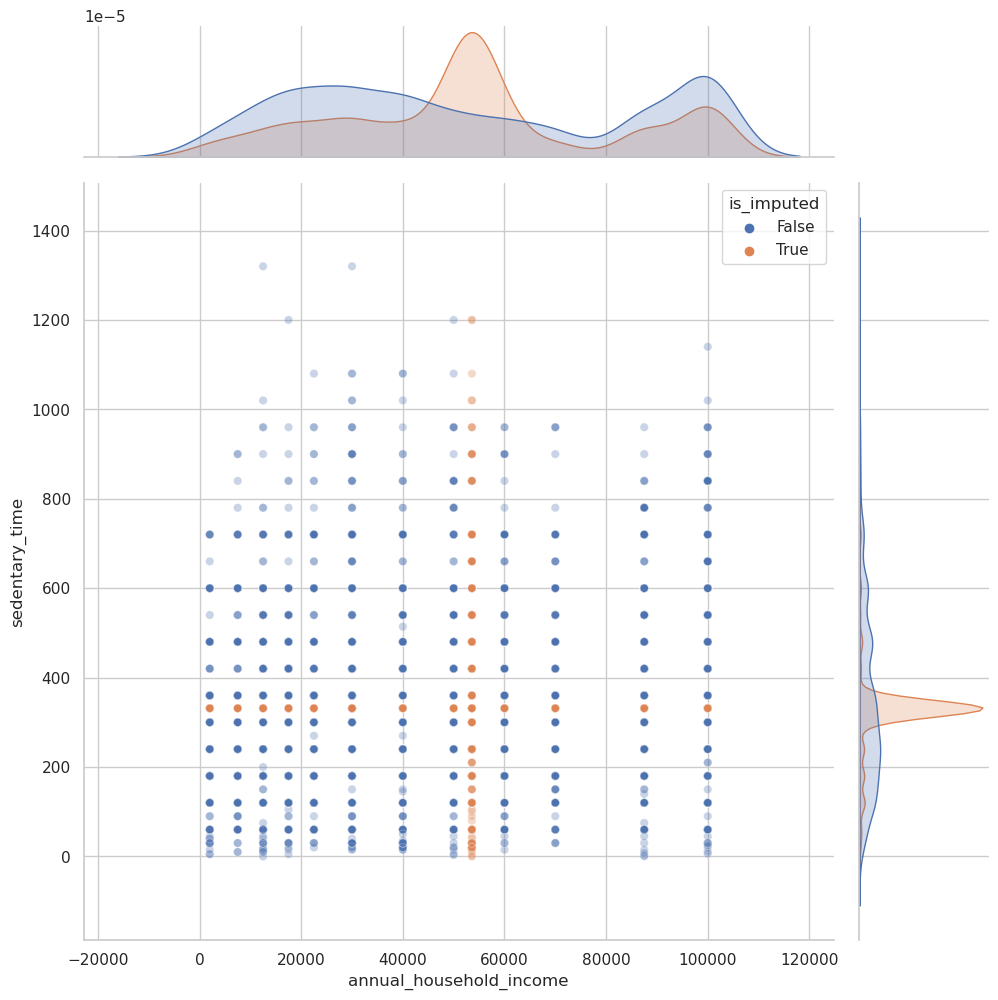

In [124]:
(
    activity_df
    .select_columns("annual_household_income", "sedentary_time")
    .missing.bind_shadow_matrix(
        true_string=True, 
        false_string=False,
        suffix="_imp"
        )
    .assign(
        annual_household_income=lambda df:df.annual_household_income.fillna(value=df.annual_household_income.mean()),
        sedentary_time=lambda df:df.sedentary_time.fillna(value=df.sedentary_time.mean())
    )
    .missing.scatter_imputation_plot(
        x="annual_household_income",
        y="sedentary_time",
        show_marginal=True,
        height=10,
        alpha=0.3
    )
)
plt.show()